(multimodal-integration:advanced-integration)=
# Advanced integration

## Motivation

In this notebook, we showcase more advanced methods and techniques for multimodal integration. Examples of such advanced techniques are unpaired integration, integration of partially overlapping data or multimodal query-to-reference mapping. These are especially useful when the measurements of various modalities were not done jointly per cell, but originate from different experiments. 

We discuss each of these cases in more detail in the corresponding sections below.

## Environment setup

In [1]:
import warnings

warnings.simplefilter(action="ignore")

import scglue
import networkx as nx
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import multigrate as mtg
import scvi
from scvi.model import TOTALVI

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

import seaborn as sns
import matplotlib.pyplot as plt

from rpy2.robjects import r
from rpy2.robjects import pandas2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

Global seed set to 0


In [2]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
})
set.seed(123)


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

## Prepare data
We continue using Multiome and CITE-seq data from the NeurIPS 2021 single cell competition {cite}`ai:luecken2021sandbox`. 

We will need:
- RNA-seq part of the multiome and ADT from the CITE-seq data for unpaired integration with [GLUE](#glue)
- paired gene expression and protein from the CITE-seq data for query-to-reference mapping with [totalVI](#totalvi)
- RNA-seq query from the CITE-seq data for query mapping with [Seurat v4](#seurat)
- CITE-seq data for [bridge](#bridge) mapping
- NeurIPS multiome and NeurIPS CITE-seq for trimodal integration and query-to-reference mapping with [multigrate](#multigrate)

Since we showcase query-to-reference mapping functionality of some methods, we split the data into a reference and a query. For the methods that we only use for integration, we also use the reference batches. 

We note that the batch names for Multiome and CITE-seq data are the same, but they are actually not the same cells.

In [3]:
cite_reference_batches = [
    "s1d1",
    "s1d2",
    "s1d3",
]  # need for totalVI, multigrate and bridge (RNA part)
multiome_reference_batches = ["s1d1", "s1d2", "s1d3"]  # need for GLUE and multigrate
cite_query_batches = ["s2d1", "s2d4"]  # need for totalVI, multigrate and bridge
multiome_query_batches = ["s2d1", "s2d4"]  # need for multigrate

In [4]:
rna_multiome = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-multiome/rna_hvg.h5ad"
)
rna_multiome

AnnData object with n_obs × n_vars = 69249 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'Site_colors', 'batch_colors', 'cell_type_colors', 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_umap'
    layers: 'counts'

In [5]:
atac_multiome = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips/atac_hvf_muon.h5ad"
)
atac_multiome

AnnData object with n_obs × n_vars = 69249 × 20000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'technology', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'binary', 'counts', 'cpm', 'tf-idf-binary', 'tf-idf-counts'

In [6]:
rna_cite = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-cite/rna_hvg.h5ad"
)
rna_cite

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [7]:
adt_cite = sc.read("/lustre/groups/ml01/workspace/daniel.strobl/neurips_cite_pp.h5ad")
adt_cite

AnnData object with n_obs × n_vars = 120502 × 136
    obs: 'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'batch_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_isotypes', 'X_pca', 'X_pcahm', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

There are some differences in `.obs_names` of RNA and ADT of CITE-seq data, so we update them to make sure they allign between modalities.

In [8]:
rna_cite.obs_names

Index(['GCATTAGCATAAGCGG-1-s1d1', 'TACAGGTGTTAGAGTA-1-s1d1',
       'AGGATCTAGGTCTACT-1-s1d1', 'GTAGAAAGTGACACAG-1-s1d1',
       'TCCGAAAAGGATCATA-1-s1d1', 'CTCCCAATCCATTGGA-1-s1d1',
       'GACCAATCAATTTCGG-1-s1d1', 'TTCCGGTAGTTGTAAG-1-s1d1',
       'ACCTGTCAGGACTGGT-1-s1d1', 'TTCGATTTCAGGACAG-1-s1d1',
       ...
       'TCTTCCTAGCCAACCC-1-s4d9', 'TTCCACGGTTGAGGAC-1-s4d9',
       'ATTCCTAGTCCAAGAG-1-s4d9', 'GCGGAAAGTACGCGTC-1-s4d9',
       'TAACTTCAGATACAGT-1-s4d9', 'GAATCACCACGGAAGT-1-s4d9',
       'GCTGGGTGTACGGATG-1-s4d9', 'TCGAAGTGTGACAGGT-1-s4d9',
       'GCAGGCTGTTGCATAC-1-s4d9', 'ACGTAACAGGTCTACT-1-s4d9'],
      dtype='object', length=90261)

In [9]:
adt_cite.obs_names

Index(['AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCACATTCTCTA-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAGTCCGCAGT-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAGTGCATACT-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAGTTGACGGA-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCATCGATACTG-1-0-0-0-0-0-0-0-0-0-0-0',
       ...
       'TTTGGTTGTCGTACTA-1-1', 'TTTGGTTTCACCTCGT-1-1', 'TTTGGTTTCGAGAACG-1-1',
       'TTTGGTTTCGATACGT-1-1', 'TTTGTTGGTAGCTTTG-1-1', 'TTTGTTGGTCCAATCA-1-1',
       'TTTGTTGGTGACTAAA-1-1', 'TTTGTTGTCCCTCTCC-1-1', 'TTTGTTGTCTAGAGCT-1-1',
       'TTTGTTGTCTCTGCCA-1-1'],
      dtype='object', length=120502)

In [10]:
adt_cite.obs_names = [
    name.split("-")[0] + "-" + name.split("-")[1] + "-" + batch
    for batch, name in zip(adt_cite.obs["donor"], adt_cite.obs_names)
]

We subset to the cells that are present in both modalities.

In [11]:
common_idx = list(set(rna_cite.obs_names).intersection(set(adt_cite.obs_names)))
rna_cite = rna_cite[common_idx].copy()
adt_cite = adt_cite[common_idx].copy()

We also copy some of the metadata from RNA to ADT.

In [12]:
adt_cite.obs = adt_cite.obs.join(rna_cite.obs[["Samplename", "cell_type"]])

Also we make sure that cells are the same in multiome data.

In [13]:
assert np.sum(rna_multiome.obs_names != atac_multiome.obs_names) == 0

Because batch names are the same for different modalities and datasets, we will need to update a bunch of batch columns in `.obs` so we create a helper function for this.

In [14]:
def update_obs_column(
    adata, obs_column_name, suffix, how="right", new_obs_column_name=None
):
    if new_obs_column_name is None:
        new_obs_column_name = f"new_{obs_column_name}"
    # otherwise can't use + operator with categorical columns
    adata.obs[obs_column_name] = adata.obs[obs_column_name].astype("str").copy()
    # create new column in .obs
    if how == "right":
        adata.obs[new_obs_column_name] = f"_{suffix}"
        adata.obs[new_obs_column_name] = (
            adata.obs[obs_column_name] + adata.obs[new_obs_column_name]
        )
    else:
        adata.obs[new_obs_column_name] = f"{suffix}_"
        adata.obs[new_obs_column_name] = (
            adata.obs[new_obs_column_name] + adata.obs[obs_column_name]
        )
    return adata

In [15]:
rna_multiome = update_obs_column(rna_multiome, "batch", "_rna_multiome")
atac_multiome = update_obs_column(atac_multiome, "batch", "_atac_multiome")
rna_cite = update_obs_column(rna_cite, "batch", "_rna_cite")
adt_cite = update_obs_column(adt_cite, "donor", "_adt_cite", "batch")

Finally we subset to the correct batches the reference datasets and the query.

In [16]:
# query
rna_multiome_query = rna_multiome[
    rna_multiome.obs["batch"].isin(multiome_query_batches)
].copy()
atac_multiome_query = atac_multiome[
    atac_multiome.obs["batch"].isin(multiome_query_batches)
].copy()
rna_cite_query = rna_cite[rna_cite.obs["batch"].isin(cite_query_batches)].copy()
adt_cite_query = adt_cite[adt_cite.obs["donor"].isin(cite_query_batches)].copy()
# reference
rna_multiome = rna_multiome[
    rna_multiome.obs["batch"].isin(multiome_reference_batches)
].copy()
atac_multiome = atac_multiome[
    atac_multiome.obs["batch"].isin(multiome_reference_batches)
].copy()
rna_cite = rna_cite[rna_cite.obs["batch"].isin(cite_reference_batches)].copy()
adt_cite = adt_cite[adt_cite.obs["donor"].isin(cite_reference_batches)].copy()

<a id='glue'></a>
## Unpaired integration with Graph Linked Unified Embedding (GLUE)

Opposed to paired integration that we demonstrated before, it is also possible to perform completely unpaired integration. In this case, there is no intersection of cell barcodes or features. Hence, we need some prior knowledge to connect different modalities.

GLUE {cite}`cao2022` is a deep learning model for unpaired integration which makes use of a regulatory graph helping connect features from different modalities. The model is based on conditional variational autoencoders, where the model learns to reconstruct while simultaneously allowing for batch correction. To guide the integration, GLUE learns an embedding for each modality for each feature by utilizing a prior knowledge graph. We demonstrate how to use GLUE to integrate unpaired RNA and ADT data using RNA part of Multiome data and ADT part of CITE-seq data from the NeurIPS competiiton (https://openproblems.bio/neurips_2021/). To construct the graph, we connect nodes from RNA modality to nodes from ADT modality if and only if the RNA node is a protein encoding gene of a given protein from ADT modality. The output of the GLUE model is a representation of each cell in a shared latent space. 

We refer the reader to GLUE tutorial to see how one can integrate unpaired RNA and ATAC with GLUE and for more details about the model https://scglue.readthedocs.io/en/latest/tutorials.html.

We follow the GLUE tutorial on how to preprocess RNA-seq. We log-normalize the raw counts, scale and calculate PCA.

In [17]:
rna_multiome.X = rna_multiome.layers["counts"].copy()
sc.pp.normalize_total(rna_multiome)
sc.pp.log1p(rna_multiome)
sc.pp.scale(rna_multiome)
sc.tl.pca(rna_multiome, n_comps=100, svd_solver="auto")

For ADT counts, we use CLR-normalized counts from `.X` and PCA calculated on the normalized values.

In [18]:
np.max(adt_cite.X)

69.27085

In [19]:
sc.tl.pca(adt_cite, n_comps=100, svd_solver="auto")

We need to make sure that protein encoding gene names and the corresponding protein names align in both data objects. We will need this later for the graph construction.

In [20]:
{
    "CD103": "ITGAE",
    "CD11b": "ITGAM",
    "CD11c": "ITGAX",
    "CD122": "IL2RB",
    "CD124": "IL4R",
    "CD127": "IL7R",
    "CD13": "ANPEP",
    "CD137": "TNFRSF9",
    "CD152": "CTLA4",
    "CD154": "CD40LG",
    "CD16": "FCGR3A",
    "CD161": "KLRB1",
    "CD185": "CXCR5",
    "CD194": "CCR4",
    "CD196": "CCR6",
    "CD20": "MS4A1",
    "CD21": "CR2",
    "CD23": "FCER2",
    "CD25": "IL2RA",
    "CD26": "DPP4",
    "CD268": "TNFRSF13C",
    "CD272": "BTLA",
    "CD278": "ICOS",
    "CD29": "ITGB1",
    "CD3": "CD3G",
    "CD303": "CLEC4C",
    "CD304": "NRP1",
    "CD314": "KLRK1",
    "CD319": "SLAMF7",
    "CD335": "NCR1",
    "CD35": "CR1",
    "CD352": "SLAMF6",
    "CD39": "ENTPD1",
    "CD49a": "ITGA1",
    "CD49f": "ITGA6",
    "CD54": "ICAM1",
    "CD56": "NCAM1",
    "CD62L": "SELL",
    "CD71": "TFRC",
    "CD73": "NT5E",
    "CD79b": "CD79B",
    "CD8": "CD8A",
    "CD85j": "LILRB1",
    "CD88": "C5AR1",
    "CD94": "KLRD1",
    "CD95": "FAS",
    "HLA-DR": "HLA-DRA",
    "IgD": "IGHD",
    "IgM": "IGHM",
    "TCR": "TRAC",
}

In [22]:
adt_cite.var_names = adt_cite.var_names.str.strip("-1")
adt_cite.var_names = [
    rename_proteins[name] if name in rename_proteins else name
    for name in adt_cite.var_names
]

### Graph construction

Before we can run GLUE integration, we need to construct a graph with prior knowledge on how feature from the two modalities are connected. The node set has to be the union of the features from all the modalities, and the edge weights have to between 0 and 1. To integrate ADT with RNA, we construct the graph the following way: we set the edge weight to 1 if the protein name is the same as the gene name and 0 for all the other edges.

In [23]:
p = np.array(adt_cite.var_names)
r = np.array(rna_multiome.var_names)
# mask entries are set to 1 where protein name is the same as gene name
mask = np.repeat(p.reshape(-1, 1), r.shape[0], axis=1) == r
mask = np.array(mask)

We rename the features so they differ for ADT and RNA modalities.

In [25]:
rna_vars = [v + "_rna" for v in rna_multiome.var_names]
prot_vars = [v + "_prot" for v in adt_cite.var_names]
rna_multiome.var_names = rna_vars
adt_cite.var_names = prot_vars

GLUE also requires each node to have an self-loop with weight 1, so we add these here too.

In [26]:
adj = pd.DataFrame(mask, index=prot_vars, columns=rna_vars)
diag_edges = adj[adj > 0].stack().index.tolist()
diag_edges = [(n1, n2, {"weight": 1.0, "sign": 1}) for n1, n2 in diag_edges]
self_loop_rna = [(g, g, {"weight": 1.0, "sign": 1}) for g in rna_vars]
self_loop_prot = [(g, g, {"weight": 1.0, "sign": 1}) for g in prot_vars]

Next we construct the actual graph object.

In [27]:
graph = nx.Graph()
graph.add_nodes_from(rna_vars)
graph.add_nodes_from(prot_vars)
graph.add_edges_from(diag_edges)
graph.add_edges_from(self_loop_prot)
graph.add_edges_from(self_loop_rna)

We should have 4136 nodes which corresponds to 4000 genes and 136 proteins. We also have 4186 edges with non-zero weights: 4136 self-loops and 50 connections between genes and proteins with the same name.

In [28]:
graph.number_of_nodes(), graph.number_of_edges()

(4136, 4186)

### Configure data

In this section we again follow the GLUE tutorial to configure the model. First, we set up the RNA encoder-decoder pair to learn to reconstruct raw counts that we assume follow NB distribution. We specify PCA embedding to be used with in the encoder.

In [31]:
scglue.models.configure_dataset(
    rna_multiome,
    "NB",
    use_highly_variable=False,
    use_batch="Samplename",
    use_layer="counts",
    use_rep="X_pca",
)

Next, we set up the ADT encoder and decoder to reconstruct normalized counts following the normal distribution and  to use PCA embeddings.

In [32]:
scglue.models.configure_dataset(
    adt_cite,
    "Normal",
    use_highly_variable=False,
    use_batch="Samplename",
    use_rep="X_pca",
)

We initialize and train the final model.

In [33]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna_multiome, "adt": adt_cite},
    graph,
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] SCGLUEModel: Setting `graph_batch_size` = 1457
[INFO] SCGLUEModel: Setting `max_epochs` = 102
[INFO] SCGLUEModel: Setting `patience` = 9
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 5
[INFO] SCGLUETrainer: Using training directory: "/tmp/GLUETMPzimh2zsp"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.192, 'g_kl': 0.04, 'g_elbo': 0.233, 'x_rna_nll': 0.241, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.248, 'x_adt_nll': 1.928, 'x_adt_kl': 0.208, 'x_adt_elbo': 2.137, 'dsc_loss': 0.666, 'vae_loss': 2.394, 'gen_loss': 2.36}, val={'g_nll': 0.188, 'g_kl': 0.04, 'g_elbo': 0.228, 'x_rna_nll': 0.243, 'x_rna_kl': 0.006, 'x_rna_elbo': 0.249, 'x_adt_nll': 1.874, 'x_adt_k

2022-10-14 13:52:55,001 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "41"...
[INFO] EarlyStopping: Restoring checkpoint "41"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (22, 22)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] SCGLUEModel: Setting `graph_batch_size` = 1457
[INFO] SCGLUEModel: Setting `align_burnin` = 17
[INFO] SCGLUEModel: Setting `max_epochs` = 102
[INFO] SCGLUEModel: Setting `patience` = 9
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 5
[INFO] SCGLUETrainer: Using training directory: "/tmp/GLUETMPqkn8cw51"
[INFO] SCGLUETr

2022-10-14 13:56:17,639 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "35"...
[INFO] EarlyStopping: Restoring checkpoint "35"...


Now we can obtain the latent representation for both modalities and concatenate them into one AnnData object for later visualization.

In [34]:
rna_multiome.obsm["X_glue"] = glue.encode_data("rna", rna_multiome)
adt_cite.obsm["X_glue"] = glue.encode_data("adt", adt_cite)

In [37]:
adt_cite.obs["modality"] = "ADT"
rna_multiome.obs["modality"] = "RNA"

combined = anndata.concat([rna_multiome, adt_cite])

Finally, we visualize the integrated latent space.

In [38]:
sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

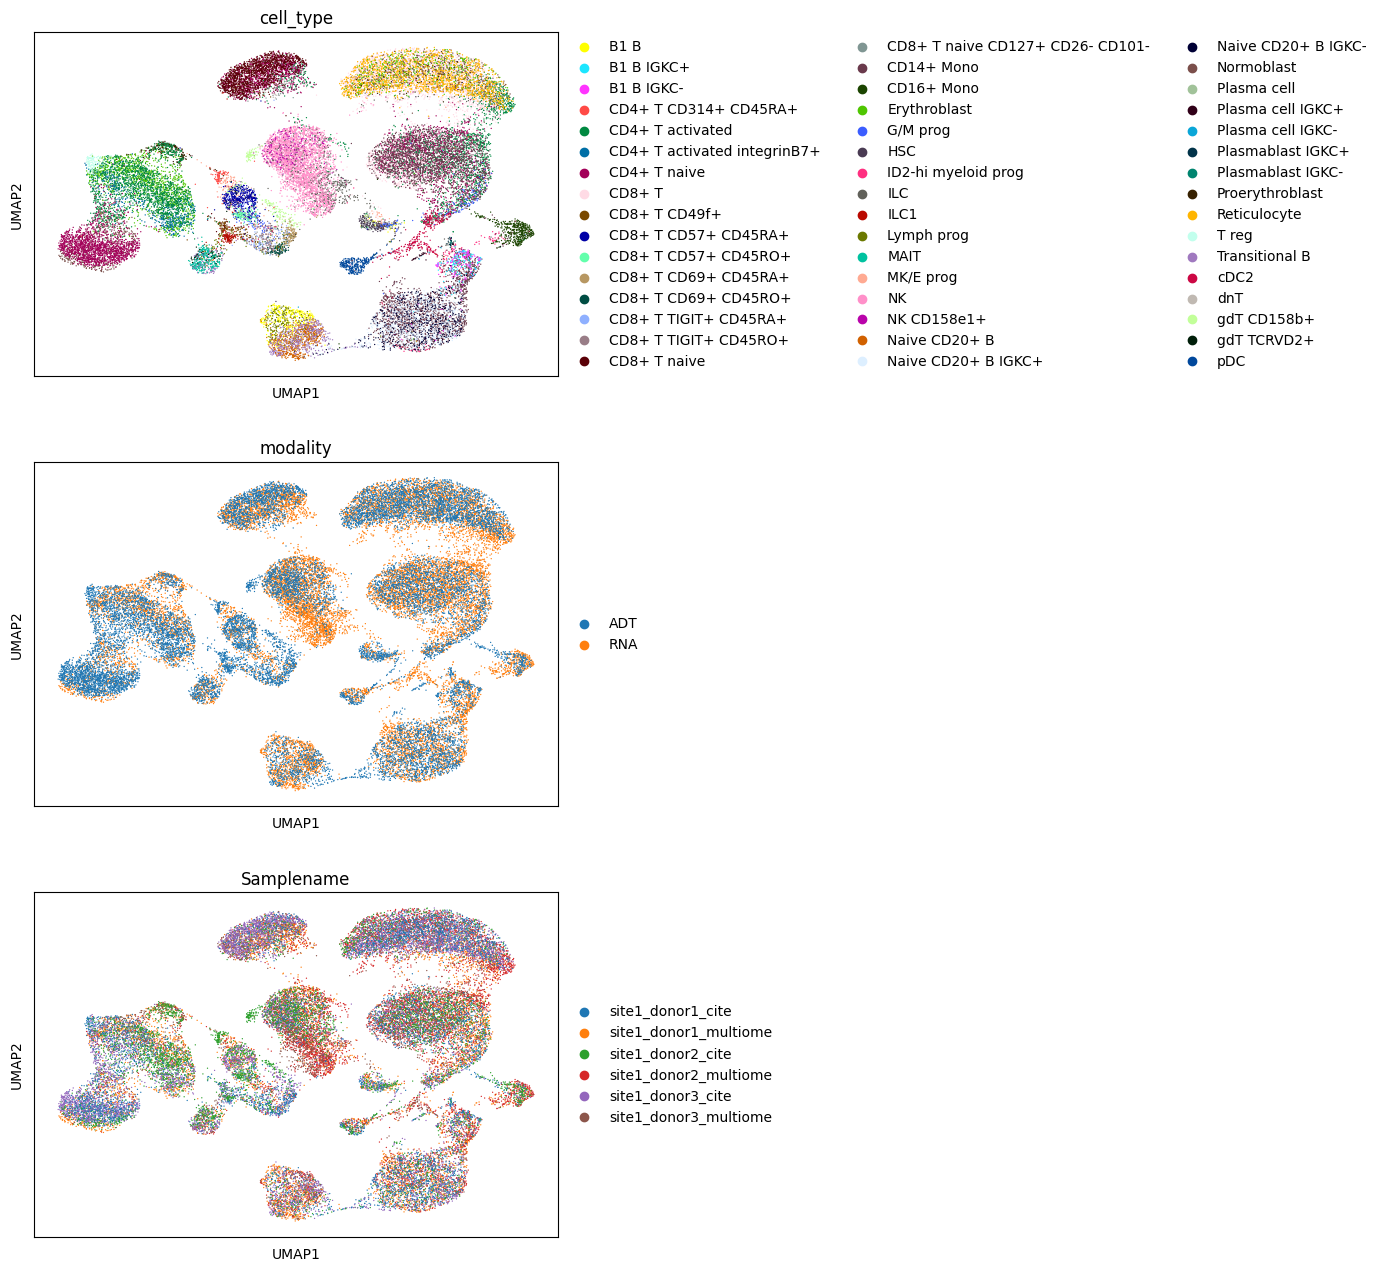

In [39]:
sc.pl.umap(combined, color=["cell_type", "modality", "Samplename"], ncols=1)

We see that the batches were well integrated as well as the two modalities. Yet again, scIB could be used to evaluate the integration.

<a id='totalvi'></a>
## Integration with partially overlapping data and query-to-reference mapping with totalVI

Another multimodal data integration scenario is when we have paired and unpaired data available at the same time, for instance, a CITE-seq and an RNA-seq datasets. This scenario is also known as mosaic integration. We might be interested in mapping the datasets into a shared latent space to make use of all the data available to us. Another use case would be to impute missing modalities (i.e. proteins abundance for RNA-seq dataset). We show how to perform these two tasks, partially overlapping integration and imputation, using totalVI {cite}`pi:gayoso2021`.

We set the protein counts of one of the batches to zeros to model the missing proteins. This helps later with mapping of the new RNA-only queries.

In [42]:
adata = rna_cite.copy()
adata.obsm["protein_counts"] = adt_cite.layers["counts"].A.copy()
adata.obsm["protein_counts"][adata.obs["batch"] == "s1d3"] = 0.0
adata

AnnData object with n_obs × n_vars = 16294 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'new_batch'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts'
    layers: 'counts'

Next, we setup the AnnData, specify the model parameters and train the model.

In [43]:
TOTALVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
    protein_expression_obsm_key="protein_counts",
)

INFO     Generating sequential column names                                                  
INFO     Found batches with missing protein expression                                       


In [44]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    n_layers_decoder=2,
    n_layers_encoder=2,
)

vae = TOTALVI(adata, **arches_params)
vae.train()

INFO     Computing empirical prior initialization for protein background.                    


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 386/400:  96%|█████████▋| 386/400 [12:10<00:26,  1.89s/it, loss=697, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1450.084. Signaling Trainer to stop.


Now we obtain the latent representation and visualize it.

In [45]:
adata.obsm["X_totalvi"] = vae.get_latent_representation()

In [46]:
sc.pp.neighbors(adata, use_rep="X_totalvi")
sc.tl.umap(adata)

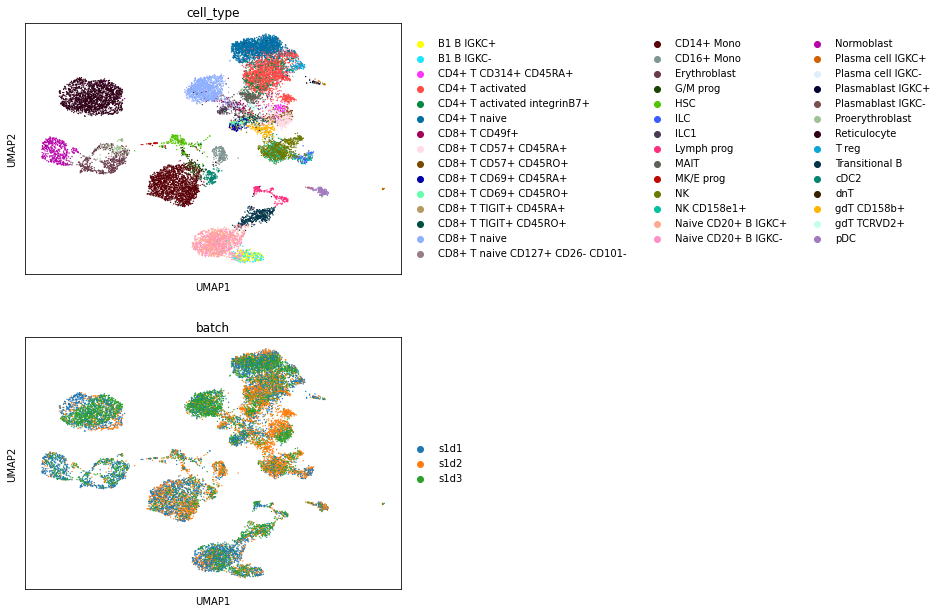

In [47]:
sc.pl.umap(adata, color=["cell_type", "batch"], ncols=1)

We see that batches as well as paired/RNA-only data are well integrated.

### Query-to-reference mapping

Now we demontrate how to map new unimodal (RNA-only) and multimodal query (CITE-seq) onto the above reference.

We mimic RNA-only query by setting the protein counts of one of the two batches to zero.

In [48]:
query = rna_cite_query.copy()
query.obsm["protein_counts"] = adt_cite_query.layers["counts"].A.copy()
query.obsm["protein_counts"][query.obs["batch"] == "s2d4"] = 0.0

We create some additional columns in `.obs` to help with the visualization later.

In [49]:
adata.obs["dataset_name"] = "Reference"
query.obs["dataset_name"] = "Query"

In [50]:
adata.obs["dataset_name_fine"] = "CITE reference"
adata.obs["dataset_name_fine"][adata.obs["batch"] == "s1d3"] = "RNA reference"
query.obs["dataset_name_fine"] = "CITE query"
query.obs["dataset_name_fine"][query.obs["batch"] == "s2d4"] = "RNA query"

Next, we update and fine-tune the model.

In [51]:
vae_q = TOTALVI.load_query_data(
    query,
    vae,
)
vae_q.train(
    plan_kwargs=dict(weight_decay=0.0, scale_adversarial_loss=0.0),
)

INFO     Found batches with missing protein expression                                       
INFO     Computing empirical prior initialization for protein background.                    


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 182/400:  46%|████▌     | 182/400 [05:38<06:45,  1.86s/it, loss=557, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1074.102. Signaling Trainer to stop.


Finally, we obtain the latent representation for the query and visualize it together with the reference. For this we concatenate reference and the query and recalculate the neighors and the UMAP.

In [52]:
query.obsm["X_totalvi_scarches"] = vae_q.get_latent_representation(query)

In [53]:
adata.obsm["X_totalvi_scarches"] = adata.obsm["X_totalvi"]

In [54]:
full_data = adata.concatenate(query, batch_key="concat_batch")
full_data

AnnData object with n_obs × n_vars = 32340 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'new_batch', '_scvi_labels', '_scvi_batch', 'dataset_name', 'dataset_name_fine', 'concat_batch'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'protein_counts', 'X_totalvi_scarches'
    layers: 'counts'

In [55]:
sc.pp.neighbors(full_data, use_rep="X_totalvi_scarches")
sc.tl.umap(full_data)

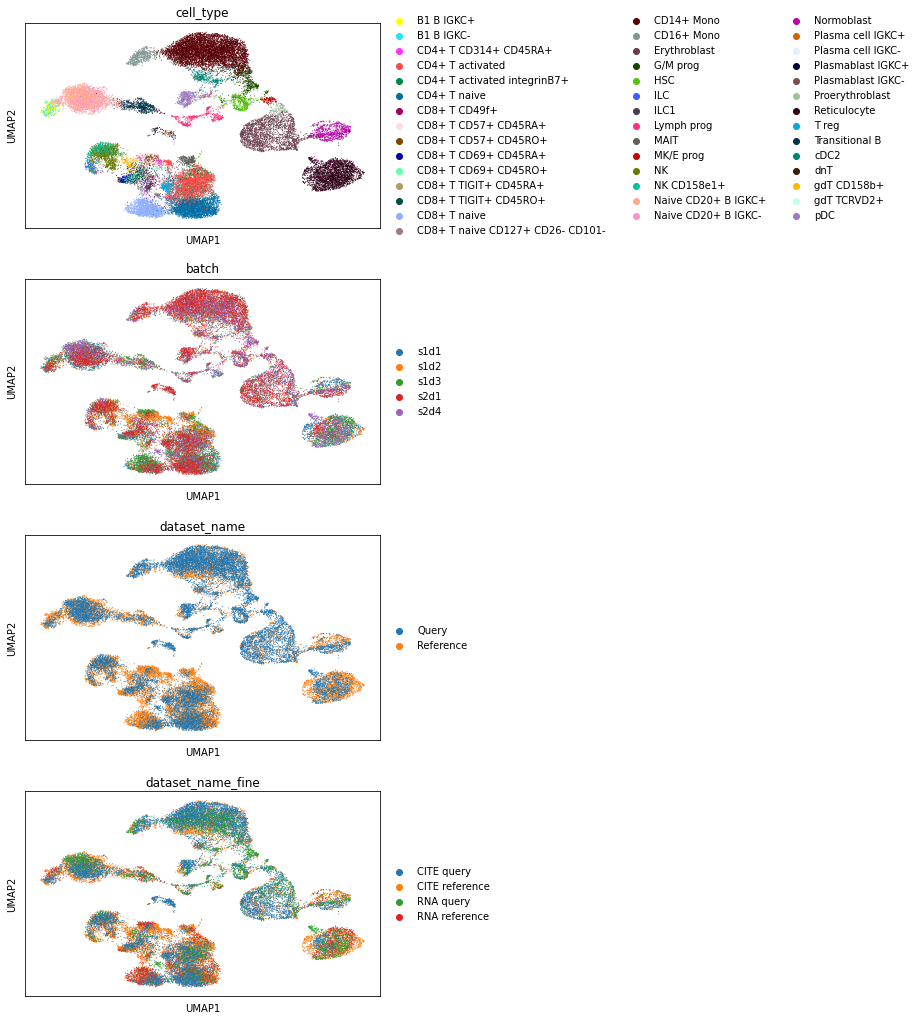

In [56]:
sc.pl.umap(
    full_data,
    color=["cell_type", "batch", "dataset_name", "dataset_name_fine"],
    ncols=1,
)

<a id='seurat'></a>
## Query mapping and imputation with Seurat's WNN

Seurat v4 allows mapping of new RNA-seq queries onto a multimodal reference integrated with weighted-nearest-neighbor (WNN) {cite}`pi:hao2021`. We use the reference we built in the paired integration notebook.

The mapping is based on finding anchors between the query and the reference. This approach also allows for missing information transfer from the reference to the query. Here we show how to predict cell types and how to impute missing modalities (protein abundance in this case).

We note that since Seurat v4 in an R library we will need to work with `anndata2ri` package (https://github.com/theislab/anndata2ri) to move all of our data from Python to R.

First, let's take a look at our reference and the query.

In [57]:
%%R
ref <- readRDS(cite, file = "wnn_ref.rds")
ref

An object of class Seurat 
4136 features across 16294 samples within 2 assays 
Active assay: RNA (4000 features, 4000 variable features)
 1 other assay present: ADT
 4 dimensional reductions calculated: pca, harmony_pca, spca, wnn.umap


In [58]:
rna_cite_query

View of AnnData object with n_obs × n_vars = 16046 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'new_batch'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We need to preprocess the query first, so we use CLR-normalized counts to calculate PCA.

In [59]:
sc.pp.pca(rna_cite_query)
rna_cite_query

AnnData object with n_obs × n_vars = 16046 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'new_batch'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism', 'pca'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [60]:
np.max(rna_cite_query.X)

9.061238

Next, we move the query from Python to R.

In [61]:
adata_ = sc.AnnData(rna_cite_query.X.copy())
adata_.obs_names = rna_cite_query.obs_names.copy()
adata_.var_names = rna_cite_query.var_names.copy()
adata_.obs["cell_type"] = rna_cite_query.obs["cell_type"].copy()
adata_.obs["batch"] = rna_cite_query.obs["batch"].copy()
adata_.obsm["X_pca"] = rna_cite_query.obsm["X_pca"].copy()

In [62]:
%%R -i adata_
query = as.Seurat(adata_, data='X', counts=NULL)
query

An object of class Seurat 
4000 features across 16046 samples within 1 assay 
Active assay: originalexp (4000 features, 0 variable features)
 1 dimensional reduction calculated: PCA


Now we need to find anchors between the reference and the query. We specify that we want to use SPCA dimentionality reduction from the reference.

In [63]:
%%R
anchors <- FindTransferAnchors(
  reference = ref,
  query = query,
  reference.reduction = "spca",
  dims = 1:20
)

Next, we map query onto the reference using the saved UMAP model to make sure that the UMAP projections stay the same for the reference and the query is mapped onto it. We additionally specify what information we want to transfer from the reference to the query with `refdata` parameter: in our case we want to predict the cell type and the protein counts.

In [64]:
%%R
query <- MapQuery(
  anchorset = anchors,
  query = query,
  reference = ref,
  refdata = list(
    cell_type = "cell_type",
    predicted_ADT = "ADT"
  ),
  reference.reduction = "spca",
  reduction.model = "wnn.umap",
  verbose=FALSE
)

Let's visualize the reference and the query together and take a look at predicted vs true cell labels.

In [65]:
%%R
ref$id <- 'reference'
query$id <- 'query'
refquery <-  merge(ref, query)
refquery[["umap"]] <- merge(ref[["wnn.umap"]], query[["ref.umap"]])

Fontconfig warning: ignoring UTF-8: not a valid region tag


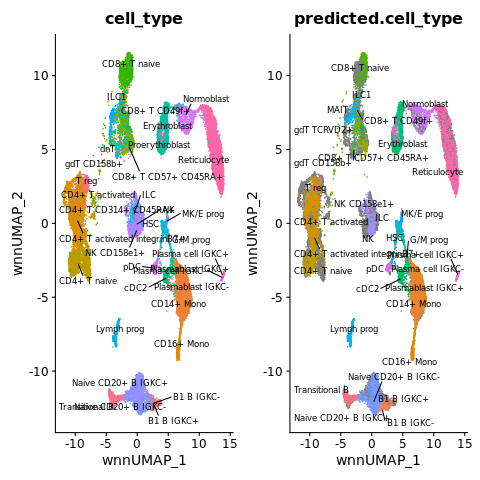

In [66]:
%%R
p1 <- DimPlot(refquery, reduction = "umap", group.by = "cell_type", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()
p2 <- DimPlot(refquery, reduction = "umap", group.by = "predicted.cell_type", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()
p1 + p2

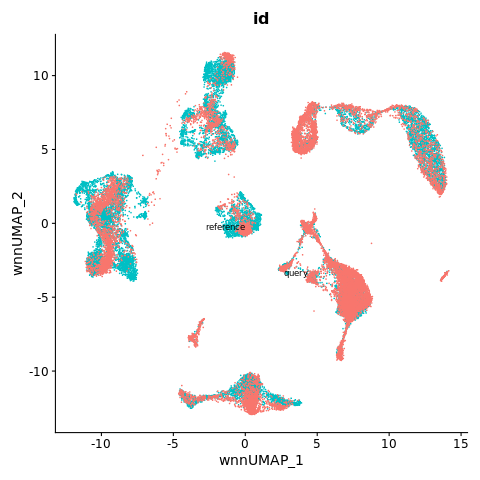

In [67]:
%%R
DimPlot(refquery, reduction = "umap", group.by = "id", label = TRUE, label.size = 3, repel = TRUE) + NoLegend()

<a id='bridge'></a>
## Mapping ADT onto an RNA atlas with bridge integration

Bridge {cite}`ai:hao2022` is a method for mapping new modalities onto an RNA-seq reference. To do so we need a so-called "bridge" dataset that contains paired data (RNA-seq and the new modality we want to map).

Since we want to showcase the bridging functionality, we assume that our reference consist of only one batch. We refer the reader to the integration vignette if there is a need to integrate batches in the reference (https://satijalab.org/seurat/articles/integration_introduction.html). As the bridge dataset we use one batch of the CITE-seq query, and as the actual ADT query we use ADT modality of the second batch in the CITE-seq query.

First, we subset the datasets to reference, bridge and query as described above.

In [68]:
rna_cite_ref = rna_cite[rna_cite.obs["batch"] == "s1d1"].copy()
rna_cite_bridge = rna_cite_query[rna_cite_query.obs["batch"] == "s2d1"].copy()

In [69]:
adt_cite_bridge = adt_cite_query[adt_cite_query.obs["donor"] == "s2d1"].copy()
adt_cite_query = adt_cite_query[adt_cite_query.obs["donor"] == "s2d4"].copy()

Next, we prepare the reference. We move the object from Python to R, normalize the data with SCTransform and calculate PCA. We also calculate the UMAP (and keep the model) that we will later use to map query onto.

In [70]:
adata_ = sc.AnnData(rna_cite_ref.layers["counts"].A.copy())
adata_.obs_names = rna_cite_ref.obs_names.copy()
adata_.var_names = rna_cite_ref.var_names.copy()
adata_.obs["cell_type"] = rna_cite_ref.obs["cell_type"].copy()

In [71]:
%%R -i adata_
ref = as.Seurat(adata_, data=NULL, counts='X')
ref

An object of class Seurat 
4000 features across 5219 samples within 1 assay 
Active assay: originalexp (4000 features, 0 variable features)


In [72]:
%%R
ref <- RenameAssays(object = ref, originalexp = "RNA", verbose=FALSE) 
ref <- SCTransform(ref, verbose=FALSE)
ref <- RunPCA(ref, verbose=FALSE)
ref <- RunUMAP(ref, dims = 1:50, return.model=TRUE, verbose=FALSE)

Next, we prepare the bridge dataset. We move both RNA and ADT objects to R, follow the same normalization procedure as above for RNA, perform CLR-normalization and calculate PCA for ADT counts.

In [73]:
adata_ = sc.AnnData(adt_cite_bridge.layers["counts"].A.copy())
adata_.obs_names = adt_cite_bridge.obs_names.copy()
adata_.var_names = adt_cite_bridge.var_names.copy()
adata_.obs["cell_type"] = adt_cite_bridge.obs["cell_type"].copy()

In [75]:
adata_

AnnData object with n_obs × n_vars = 10465 × 136
    obs: 'cell_type'

In [76]:
%%R -i adata_
adt <- as.Seurat(adata_, data=NULL, counts='X')

In [77]:
adata_ = sc.AnnData(rna_cite_bridge.layers["counts"].A.copy())
adata_.obs_names = rna_cite_bridge.obs_names.copy()
adata_.var_names = rna_cite_bridge.var_names.copy()
adata_.obs["cell_type"] = rna_cite_bridge.obs["cell_type"].copy()

In [78]:
%%R -i adata_
rna = as.Seurat(adata_, data=NULL, counts='X')
cite <- rna
cite <- RenameAssays(object = cite, originalexp = "RNA") 
cite[["ADT"]] <- CreateAssayObject(counts = adt@assays$originalexp@data)

In [79]:
%%R
DefaultAssay(cite) <- "RNA"
VariableFeatures(cite) <- rownames(cite)
cite <- SCTransform(cite, verbose = FALSE) 

In [80]:
%%R
DefaultAssay(cite) <- "ADT"
VariableFeatures(cite) <- rownames(cite)
cite <- NormalizeData(cite, normalization.method = 'CLR', margin = 2, verbose=FALSE)
cite <- ScaleData(cite, verbose=FALSE)

Finally, we prepare the ADT query the same way as the bridge ADT above.

In [81]:
adata_ = sc.AnnData(adt_cite_query.layers["counts"].A.copy())
adata_.obs_names = adt_cite_query.obs_names.copy()
adata_.var_names = adt_cite_query.var_names.copy()
adata_.obs["cell_type"] = adt_cite_query.obs["cell_type"].copy()

In [82]:
%%R -i adata_
query <- as.Seurat(adata_, data=NULL, counts='X')
query <- RenameAssays(object = query, originalexp = "ADT", verbose=FALSE) 
VariableFeatures(query) <- rownames(query)
query <- NormalizeData(query, normalization.method = 'CLR', margin = 2, verbose=FALSE)
query <- ScaleData(query, verbose=FALSE)
query <- RunPCA(query, verbose=FALSE, reduction.name = 'apca')

Now we can perform the bridge integration. The final step of query mapping is the same as with Seurat v4 query mapping so we can also predict cell types for the query data.

In [83]:
%%R
dims.adt <- 1:50
dims.rna <- 1:50

DefaultAssay(cite) <-  "RNA"
DefaultAssay(ref) <- "SCT"
obj.rna.ext <- PrepareBridgeReference(
    reference = ref,
    bridge = cite,
    bridge.query.assay = "ADT",
    reference.reduction = "pca",
    reference.dims = dims.rna,
    normalization.method = "SCT",
    verbose = FALSE
)

  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  
  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


In [84]:
%%R
bridge.anchor <- FindBridgeTransferAnchors(
    extended.reference = obj.rna.ext, 
    query = query,
    reduction = "pcaproject",
    dims = dims.adt,
    verbose = FALSE
)

  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


In [85]:
%%R
query <- MapQuery(
    anchorset = bridge.anchor, 
    reference = ref, 
    query = query, 
    refdata = list(
        cell_type = "cell_type"
    ),
    reduction.model = "umap",
    verbose = FALSE
)

Let's visualize the result.

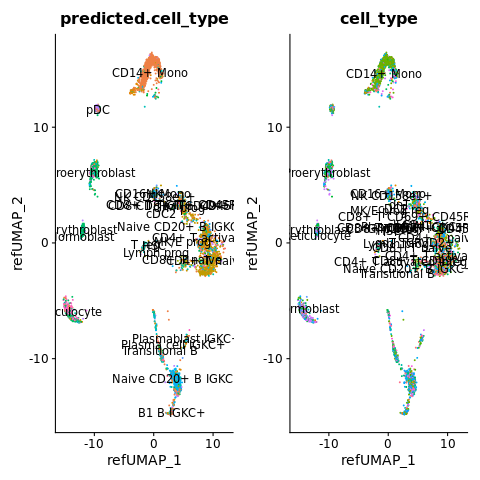

In [86]:
%%R
p1 <- DimPlot(query, group.by = "predicted.cell_type", reduction = "ref.umap", label = TRUE) + NoLegend()
p2 <- DimPlot(query, group.by = "cell_type", reduction = "ref.umap", label = TRUE) + NoLegend()
p1 + p2

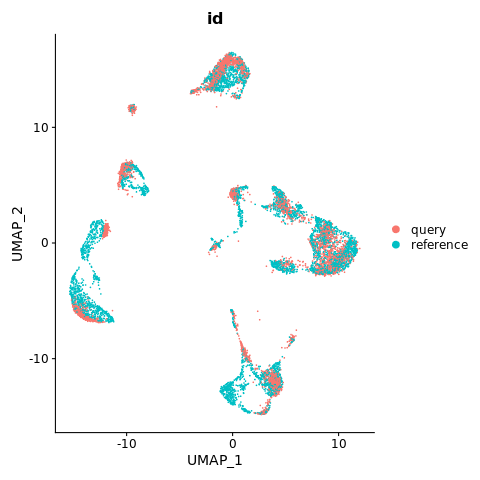

In [87]:
%%R
ref$id <- 'reference'
query$id <- 'query'
refquery <-  merge(ref, query)
refquery[["umap"]] <- merge(ref[["umap"]], query[["ref.umap"]])
DimPlot(refquery, group.by = 'id', shuffle = TRUE)

<a id='multigrate'></a>
## Trimodal integration and query-to-reference mapping with multigrate

In our final example, we will build a trimodal reference atlas using RNA, ATAC and ADT as three modalities. Multigrate {cite}`ai:lotfollahi2022` is a deep-learning method based on conditional autoencoders. Data from each modality is fed into a separate encoder which outputs the parameters of the marginal distribution, then the parameters of the joint distribution are calculated with product of experts (PoE) {cite}`ai:lee2021`. The conditional decoders then learn to reconstruct the original input data while simultaneously correction for batch effects. PoE allows the integration of data with missing measurements for some modalities by setting the corresponding marginals to a non-informative distribution. Multigrate also follows scArches {cite}`ai:lotfollahi2022_arches` framework to allow query-to-reference mapping of unimodal as well as multimodal queries.

### Building the reference

First, we load data that has 4000 highly variable genes that are common for the scRNA-seq and scRNA-seq from the CITE-seq and the multiome experiment respectively.

In [88]:
rna1 = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips/rna_hvg_cite.h5ad"
)
rna1_ref = rna1[adt_cite.obs_names].copy()
rna1_query = rna1[adt_cite_query.obs_names].copy()
rna1_ref.shape, rna1_query.shape

((16294, 4000), (16046, 4000))

In [89]:
rna2 = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/trimodal_neurips/rna_hvg_multiome.h5ad"
)
rna2_ref = rna2[atac_multiome.obs_names].copy()
rna2_query = rna2[atac_multiome_query.obs_names].copy()
rna2_ref.shape, rna2_query.shape

((17243, 4000), (10331, 4000))

Next, we concatenate all the data into one AnnData object specifying how the data is paired and which layers to use.

In [90]:
adata = mtg.data.organize_multiome_anndatas(
    adatas=[[rna1_ref, rna2_ref], [None, atac_multiome], [adt_cite, None]],
    groups=[[0, 1], [0, 1], [0, 1]],
    layers=[["counts", "counts"], [None, "cpm"], [None, None]],
    modality_lengths=[4000, 20000, 136],
)
adata

AnnData object with n_obs × n_vars = 33537 × 24136
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'technology', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split', 'group', 'concat_batch'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'fea

Next, we register covariates that the model will correct for in the latent space.

In [91]:
mtg.model.MultiVAE.setup_anndata(
    adata, categorical_covariate_keys=["technology", "Samplename"], rna_indices_end=4000
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 33537 cells, 24136 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Next, we initialize the model and train it. We refer the reader to the multigrate tutorial on how to find good hyperparameters.

In [92]:
model = mtg.model.MultiVAE(
    adata,
    modality_lengths=[4000, 20000, 136],
    losses=["nb", "mse", "mse"],
    loss_coefs={
        "kl": 1e-3,
        "integ": 10000,
    },
    integrate_on="technology",
    add_shared_decoder=False,
    z_dim=15,
    cond_dim=10,
    dropout=0.2,
    n_layers_encoders=[1, 1, 1],
    n_layers_decoders=[1, 1, 1],
    mmd="marginal",
)

In [93]:
model.train(max_epochs=100, lr=1e-3)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/100:   1%|          | 1/100 [00:18<29:41, 17.99s/it, loss=4.24e+03, v_num=1]

Metric elbo_validation improved. New best score: 3529.220


Epoch 2/100:   2%|▏         | 2/100 [00:27<21:20, 13.06s/it, loss=3.28e+03, v_num=1]

Metric elbo_validation improved by 755.770 >= min_delta = 0.0. New best score: 2773.450


Epoch 3/100:   3%|▎         | 3/100 [00:37<18:30, 11.45s/it, loss=3.11e+03, v_num=1]

Metric elbo_validation improved by 250.024 >= min_delta = 0.0. New best score: 2523.426


Epoch 4/100:   4%|▍         | 4/100 [00:46<16:43, 10.45s/it, loss=2.84e+03, v_num=1]

Metric elbo_validation improved by 123.635 >= min_delta = 0.0. New best score: 2399.791


Epoch 5/100:   5%|▌         | 5/100 [00:55<15:43,  9.93s/it, loss=2.91e+03, v_num=1]

Metric elbo_validation improved by 56.637 >= min_delta = 0.0. New best score: 2343.154


Epoch 6/100:   6%|▌         | 6/100 [01:04<15:04,  9.62s/it, loss=2.77e+03, v_num=1]

Metric elbo_validation improved by 51.217 >= min_delta = 0.0. New best score: 2291.938


Epoch 7/100:   7%|▋         | 7/100 [01:13<14:40,  9.46s/it, loss=2.92e+03, v_num=1]

Metric elbo_validation improved by 49.911 >= min_delta = 0.0. New best score: 2242.027


Epoch 8/100:   8%|▊         | 8/100 [01:22<14:25,  9.41s/it, loss=2.88e+03, v_num=1]

Metric elbo_validation improved by 25.709 >= min_delta = 0.0. New best score: 2216.317


Epoch 9/100:   9%|▉         | 9/100 [01:31<14:07,  9.32s/it, loss=2.84e+03, v_num=1]

Metric elbo_validation improved by 25.617 >= min_delta = 0.0. New best score: 2190.700


Epoch 10/100:  10%|█         | 10/100 [01:41<14:04,  9.38s/it, loss=2.9e+03, v_num=1] 

Metric elbo_validation improved by 8.071 >= min_delta = 0.0. New best score: 2182.629


Epoch 11/100:  11%|█         | 11/100 [01:50<13:47,  9.30s/it, loss=2.59e+03, v_num=1]

Metric elbo_validation improved by 15.995 >= min_delta = 0.0. New best score: 2166.634


Epoch 12/100:  12%|█▏        | 12/100 [01:59<13:35,  9.26s/it, loss=2.74e+03, v_num=1]

Metric elbo_validation improved by 6.343 >= min_delta = 0.0. New best score: 2160.291


Epoch 13/100:  13%|█▎        | 13/100 [02:08<13:20,  9.20s/it, loss=2.68e+03, v_num=1]

Metric elbo_validation improved by 14.863 >= min_delta = 0.0. New best score: 2145.428


Epoch 14/100:  14%|█▍        | 14/100 [02:17<13:10,  9.19s/it, loss=2.79e+03, v_num=1]

Metric elbo_validation improved by 10.984 >= min_delta = 0.0. New best score: 2134.444


Epoch 15/100:  15%|█▌        | 15/100 [02:26<13:01,  9.19s/it, loss=2.72e+03, v_num=1]

Metric elbo_validation improved by 7.768 >= min_delta = 0.0. New best score: 2126.676


Epoch 17/100:  17%|█▋        | 17/100 [02:46<13:08,  9.50s/it, loss=2.68e+03, v_num=1]

Metric elbo_validation improved by 3.347 >= min_delta = 0.0. New best score: 2123.329


Epoch 18/100:  18%|█▊        | 18/100 [02:55<12:52,  9.42s/it, loss=2.62e+03, v_num=1]

Metric elbo_validation improved by 13.159 >= min_delta = 0.0. New best score: 2110.170


Epoch 20/100:  20%|██        | 20/100 [03:15<12:58,  9.74s/it, loss=2.68e+03, v_num=1]

Metric elbo_validation improved by 6.831 >= min_delta = 0.0. New best score: 2103.339


Epoch 21/100:  21%|██        | 21/100 [03:25<12:47,  9.71s/it, loss=2.64e+03, v_num=1]

Metric elbo_validation improved by 5.440 >= min_delta = 0.0. New best score: 2097.899


Epoch 22/100:  22%|██▏       | 22/100 [03:34<12:30,  9.63s/it, loss=2.69e+03, v_num=1]

Metric elbo_validation improved by 2.058 >= min_delta = 0.0. New best score: 2095.841


Epoch 23/100:  23%|██▎       | 23/100 [03:44<12:18,  9.59s/it, loss=2.57e+03, v_num=1]

Metric elbo_validation improved by 2.637 >= min_delta = 0.0. New best score: 2093.204


Epoch 24/100:  24%|██▍       | 24/100 [03:52<11:51,  9.37s/it, loss=2.56e+03, v_num=1]

Metric elbo_validation improved by 5.018 >= min_delta = 0.0. New best score: 2088.186


Epoch 25/100:  25%|██▌       | 25/100 [04:01<11:26,  9.16s/it, loss=2.62e+03, v_num=1]

Metric elbo_validation improved by 0.310 >= min_delta = 0.0. New best score: 2087.876


Epoch 26/100:  26%|██▌       | 26/100 [04:10<11:06,  9.00s/it, loss=2.68e+03, v_num=1]

Metric elbo_validation improved by 4.596 >= min_delta = 0.0. New best score: 2083.280


Epoch 28/100:  28%|██▊       | 28/100 [04:28<10:46,  8.98s/it, loss=2.67e+03, v_num=1]

Metric elbo_validation improved by 0.973 >= min_delta = 0.0. New best score: 2082.307


Epoch 30/100:  30%|███       | 30/100 [04:46<10:38,  9.13s/it, loss=2.62e+03, v_num=1]

Metric elbo_validation improved by 1.533 >= min_delta = 0.0. New best score: 2080.773


Epoch 31/100:  31%|███       | 31/100 [04:55<10:25,  9.06s/it, loss=2.66e+03, v_num=1]

Metric elbo_validation improved by 2.276 >= min_delta = 0.0. New best score: 2078.497


Epoch 32/100:  32%|███▏      | 32/100 [05:04<10:10,  8.98s/it, loss=2.62e+03, v_num=1]

Metric elbo_validation improved by 4.541 >= min_delta = 0.0. New best score: 2073.956


Epoch 36/100:  36%|███▌      | 36/100 [05:40<09:40,  9.07s/it, loss=2.65e+03, v_num=1]

Metric elbo_validation improved by 3.791 >= min_delta = 0.0. New best score: 2070.166


Epoch 37/100:  37%|███▋      | 37/100 [05:49<09:26,  9.00s/it, loss=2.73e+03, v_num=1]

Metric elbo_validation improved by 0.063 >= min_delta = 0.0. New best score: 2070.102


Epoch 40/100:  40%|████      | 40/100 [06:16<08:53,  8.89s/it, loss=2.58e+03, v_num=1]

Metric elbo_validation improved by 3.662 >= min_delta = 0.0. New best score: 2066.440


Epoch 42/100:  42%|████▏     | 42/100 [06:33<08:32,  8.83s/it, loss=2.52e+03, v_num=1]

Metric elbo_validation improved by 0.764 >= min_delta = 0.0. New best score: 2065.676


Epoch 47/100:  47%|████▋     | 47/100 [07:19<08:07,  9.20s/it, loss=2.63e+03, v_num=1]

Metric elbo_validation improved by 1.411 >= min_delta = 0.0. New best score: 2064.264


Epoch 51/100:  51%|█████     | 51/100 [07:57<07:36,  9.32s/it, loss=2.58e+03, v_num=1]

Metric elbo_validation improved by 3.132 >= min_delta = 0.0. New best score: 2061.132


Epoch 64/100:  64%|██████▍   | 64/100 [09:53<05:22,  8.95s/it, loss=2.53e+03, v_num=1]

Metric elbo_validation improved by 0.539 >= min_delta = 0.0. New best score: 2060.594


Epoch 100/100: 100%|██████████| 100/100 [15:18<00:00,  9.18s/it, loss=2.59e+03, v_num=1]


Finally, we obtain the latent representation and visualize the result.

In [94]:
model.get_latent_representation()
adata

AnnData object with n_obs × n_vars = 33537 × 24136
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'GEX_n_counts', 'GEX_n_genes', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'ATAC_pseudotime_order', 'technology', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay', 'split', 'group', 'concat_batch', 'size_factors', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-

In [95]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

In [96]:
adata.obs["technology"] = (
    adata.obs["technology"]
    .astype("category")
    .cat.rename_categories({"0": "CITE-seq", "1": "multiome"})
)

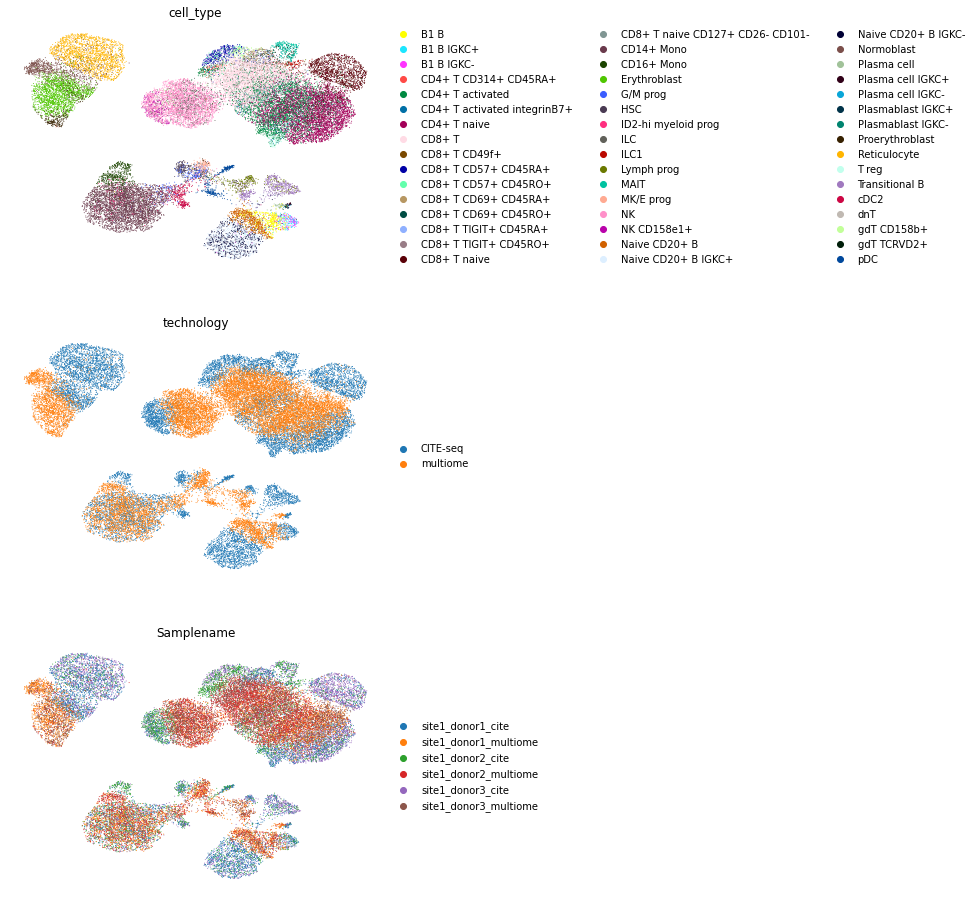

In [97]:
sc.pl.umap(
    adata, color=["cell_type", "technology", "Samplename"], ncols=1, frameon=False
)

### Querying the trimodal reference

We repeat the same steps for the settin up the query as for the reference before.

In [98]:
query = mtg.data.organize_multiome_anndatas(
    adatas=[
        [rna1_query, rna2_query],
        [None, atac_multiome_query],
        [adt_cite_query, None],
    ],
    groups=[[0, 1], [0, 1], [0, 1]],
    layers=[["counts", "counts"], [None, "cpm"], [None, None]],
    modality_lengths=[4000, 20000, 136],
)

In [99]:
mtg.model.MultiVAE.setup_anndata(
    query,
    categorical_covariate_keys=["Samplename", "technology"],
    rna_indices_end=4000,
)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 26377 cells, 24136 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Let's imitate unimodal queries by masking with zeros the snRNA part of one multiome batch and ADT part of one CITE-seq batch in the query. We get one ATAC-only query batch and one scRNA-only query batch respectively.

In [100]:
idx_atac_query = query.obs["Samplename"] == "site2_donor4_multiome"
idx_scrna_query = query.obs["Samplename"] == "site2_donor1_cite"

idx_mutiome_query = query.obs["Samplename"] == "site2_donor1_multiome"
idx_cite_query = query.obs["Samplename"] == "site2_donor4_cite"

np.sum(idx_atac_query), np.sum(idx_scrna_query), np.sum(idx_mutiome_query), np.sum(
    idx_cite_query
),

(6111, 10465, 4220, 5581)

In [101]:
query[idx_atac_query, :4000].X = 0
query[idx_scrna_query, 4000:].X = 0

We update the model by adding new weights to the new batches in the query and fine-tune those weights.

In [102]:
q_model = mtg.model.MultiVAE.load_query_data(query, model)

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 26377 cells, 24136 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 1 extra continuous covariates.                                                  


In [103]:
q_model.train(max_epochs=100, lr=1e-3, batch_size=256, weight_decay=0)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/100:   1%|          | 1/100 [00:02<04:31,  2.75s/it, loss=2.53e+03, v_num=1]

Metric elbo_validation improved. New best score: 1716.027


Epoch 2/100:   2%|▏         | 2/100 [00:05<04:38,  2.85s/it, loss=2.54e+03, v_num=1]

Metric elbo_validation improved by 10.123 >= min_delta = 0.0. New best score: 1705.904


Epoch 3/100:   3%|▎         | 3/100 [00:08<04:33,  2.82s/it, loss=2.22e+03, v_num=1]

Metric elbo_validation improved by 12.079 >= min_delta = 0.0. New best score: 1693.825


Epoch 4/100:   4%|▍         | 4/100 [00:11<04:29,  2.81s/it, loss=2.38e+03, v_num=1]

Metric elbo_validation improved by 26.667 >= min_delta = 0.0. New best score: 1667.159


Epoch 5/100:   5%|▌         | 5/100 [00:14<04:29,  2.83s/it, loss=2.37e+03, v_num=1]

Metric elbo_validation improved by 3.923 >= min_delta = 0.0. New best score: 1663.236


Epoch 6/100:   6%|▌         | 6/100 [00:16<04:24,  2.81s/it, loss=2.13e+03, v_num=1]

Metric elbo_validation improved by 15.851 >= min_delta = 0.0. New best score: 1647.384


Epoch 7/100:   7%|▋         | 7/100 [00:19<04:21,  2.82s/it, loss=2.41e+03, v_num=1]

Metric elbo_validation improved by 10.674 >= min_delta = 0.0. New best score: 1636.711


Epoch 8/100:   8%|▊         | 8/100 [00:22<04:19,  2.82s/it, loss=2.33e+03, v_num=1]

Metric elbo_validation improved by 8.263 >= min_delta = 0.0. New best score: 1628.447


Epoch 9/100:   9%|▉         | 9/100 [00:25<04:15,  2.81s/it, loss=2.21e+03, v_num=1]

Metric elbo_validation improved by 8.541 >= min_delta = 0.0. New best score: 1619.906


Epoch 10/100:  10%|█         | 10/100 [00:28<04:12,  2.80s/it, loss=2.39e+03, v_num=1]

Metric elbo_validation improved by 14.244 >= min_delta = 0.0. New best score: 1605.663


Epoch 11/100:  11%|█         | 11/100 [00:30<04:10,  2.81s/it, loss=2.5e+03, v_num=1] 

Metric elbo_validation improved by 9.183 >= min_delta = 0.0. New best score: 1596.479


Epoch 12/100:  12%|█▏        | 12/100 [00:33<04:07,  2.82s/it, loss=2.31e+03, v_num=1]

Metric elbo_validation improved by 3.284 >= min_delta = 0.0. New best score: 1593.195


Epoch 13/100:  13%|█▎        | 13/100 [00:36<04:05,  2.82s/it, loss=2.33e+03, v_num=1]

Metric elbo_validation improved by 9.922 >= min_delta = 0.0. New best score: 1583.273


Epoch 14/100:  14%|█▍        | 14/100 [00:39<04:01,  2.81s/it, loss=2.28e+03, v_num=1]

Metric elbo_validation improved by 11.756 >= min_delta = 0.0. New best score: 1571.517


Epoch 16/100:  16%|█▌        | 16/100 [00:45<03:58,  2.84s/it, loss=2.45e+03, v_num=1]

Metric elbo_validation improved by 0.204 >= min_delta = 0.0. New best score: 1571.313


Epoch 17/100:  17%|█▋        | 17/100 [00:47<03:55,  2.83s/it, loss=2.16e+03, v_num=1]

Metric elbo_validation improved by 2.067 >= min_delta = 0.0. New best score: 1569.247


Epoch 18/100:  18%|█▊        | 18/100 [00:50<03:52,  2.84s/it, loss=2.2e+03, v_num=1] 

Metric elbo_validation improved by 15.978 >= min_delta = 0.0. New best score: 1553.269


Epoch 19/100:  19%|█▉        | 19/100 [00:53<03:48,  2.82s/it, loss=2.14e+03, v_num=1]

Metric elbo_validation improved by 1.175 >= min_delta = 0.0. New best score: 1552.094


Epoch 21/100:  21%|██        | 21/100 [00:59<03:42,  2.81s/it, loss=2.25e+03, v_num=1]

Metric elbo_validation improved by 3.262 >= min_delta = 0.0. New best score: 1548.832


Epoch 22/100:  22%|██▏       | 22/100 [01:02<03:39,  2.82s/it, loss=2.26e+03, v_num=1]

Metric elbo_validation improved by 4.152 >= min_delta = 0.0. New best score: 1544.680


Epoch 23/100:  23%|██▎       | 23/100 [01:04<03:37,  2.82s/it, loss=2.29e+03, v_num=1]

Metric elbo_validation improved by 1.952 >= min_delta = 0.0. New best score: 1542.728


Epoch 24/100:  24%|██▍       | 24/100 [01:07<03:34,  2.82s/it, loss=2.27e+03, v_num=1]

Metric elbo_validation improved by 7.518 >= min_delta = 0.0. New best score: 1535.211


Epoch 26/100:  26%|██▌       | 26/100 [01:13<03:26,  2.79s/it, loss=2.2e+03, v_num=1] 

Metric elbo_validation improved by 5.448 >= min_delta = 0.0. New best score: 1529.763


Epoch 29/100:  29%|██▉       | 29/100 [01:21<03:17,  2.79s/it, loss=2.37e+03, v_num=1]

Metric elbo_validation improved by 4.638 >= min_delta = 0.0. New best score: 1525.125


Epoch 30/100:  30%|███       | 30/100 [01:24<03:15,  2.79s/it, loss=2.29e+03, v_num=1]

Metric elbo_validation improved by 1.670 >= min_delta = 0.0. New best score: 1523.454


Epoch 33/100:  33%|███▎      | 33/100 [01:32<03:06,  2.79s/it, loss=2.33e+03, v_num=1]

Metric elbo_validation improved by 4.190 >= min_delta = 0.0. New best score: 1519.264


Epoch 35/100:  35%|███▌      | 35/100 [01:38<03:02,  2.80s/it, loss=2.37e+03, v_num=1]

Metric elbo_validation improved by 2.490 >= min_delta = 0.0. New best score: 1516.774


Epoch 39/100:  39%|███▉      | 39/100 [01:49<02:48,  2.77s/it, loss=2.24e+03, v_num=1]

Metric elbo_validation improved by 0.360 >= min_delta = 0.0. New best score: 1516.413


Epoch 41/100:  41%|████      | 41/100 [01:55<02:45,  2.80s/it, loss=2.24e+03, v_num=1]

Metric elbo_validation improved by 3.880 >= min_delta = 0.0. New best score: 1512.533


Epoch 44/100:  44%|████▍     | 44/100 [02:03<02:38,  2.84s/it, loss=2.14e+03, v_num=1]

Metric elbo_validation improved by 1.922 >= min_delta = 0.0. New best score: 1510.611


Epoch 51/100:  51%|█████     | 51/100 [02:23<02:24,  2.95s/it, loss=2.3e+03, v_num=1] 

Metric elbo_validation improved by 6.557 >= min_delta = 0.0. New best score: 1504.054


Epoch 70/100:  70%|███████   | 70/100 [03:17<01:24,  2.80s/it, loss=2.11e+03, v_num=1]

Metric elbo_validation improved by 1.597 >= min_delta = 0.0. New best score: 1502.457


Epoch 100/100: 100%|██████████| 100/100 [04:42<00:00,  2.82s/it, loss=2.19e+03, v_num=1]


We obtain the latent representation for query and the reference from the updated model. Note that the representation of the reference is the same as before up to some sampling noise.

In [104]:
q_model.get_latent_representation(batch_size=256, adata=query)

In [105]:
q_model.get_latent_representation(batch_size=256, adata=adata)

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 33537 cells, 24136 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 1 extra continuous covariates.                                                  


Finally, we concatenate the reference and the query, and visualize both on a UMAP.

In [106]:
adata.obs["reference"] = "reference"
query.obs["reference"] = "query"

query.obs.loc[idx_atac_query, "type_of_query"] = "ATAC query"
query.obs.loc[idx_scrna_query, "type_of_query"] = "scRNA query"
query.obs.loc[idx_mutiome_query, "type_of_query"] = "multiome query"
query.obs.loc[idx_cite_query, "type_of_query"] = "CITE-seq query"

In [107]:
query.obs["technology"] = (
    query.obs["technology"]
    .astype("category")
    .cat.rename_categories({"0": "CITE-seq", "1": "multiome"})
)

In [108]:
adata_both = anndata.concatenate([adata, query])

In [109]:
sc.pp.neighbors(adata_both, use_rep="latent")
sc.tl.umap(adata_both)

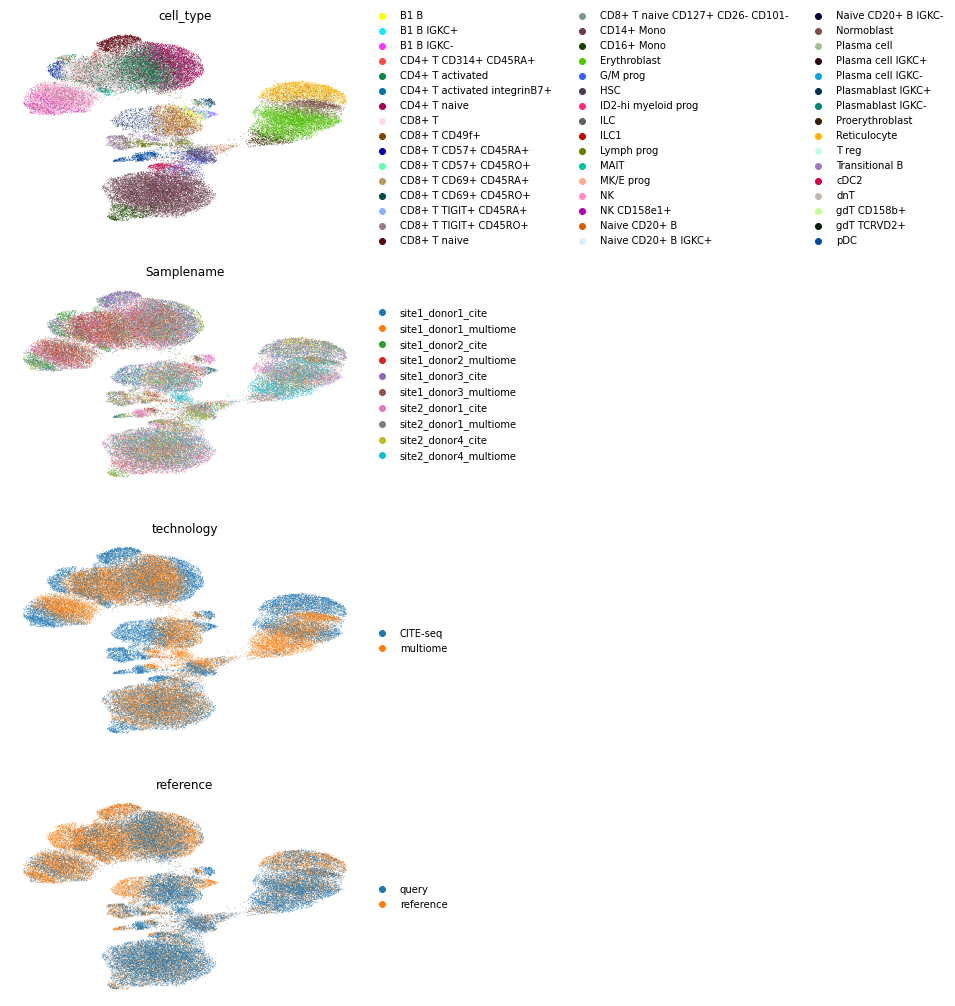

In [110]:
sc.pl.umap(
    adata_both,
    color=["cell_type", "Samplename", "technology", "reference"],
    ncols=1,
    frameon=False,
)

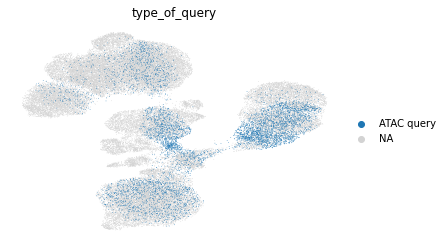

In [111]:
sc.pl.umap(
    adata_both, color="type_of_query", ncols=1, frameon=False, groups=["ATAC query"]
)

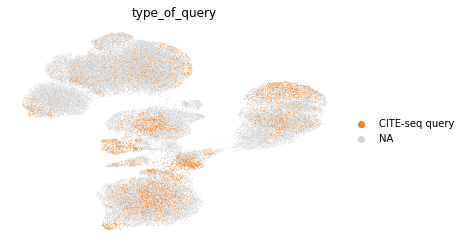

In [112]:
sc.pl.umap(
    adata_both, color="type_of_query", ncols=1, frameon=False, groups=["CITE-seq query"]
)

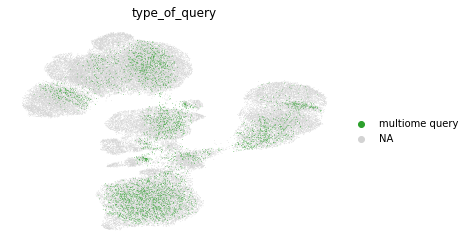

In [113]:
sc.pl.umap(
    adata_both, color="type_of_query", ncols=1, frameon=False, groups=["multiome query"]
)

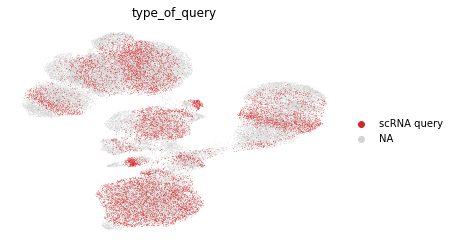

In [114]:
sc.pl.umap(
    adata_both, color="type_of_query", ncols=1, frameon=False, groups=["scRNA query"]
)

We observe that the query cell types are mapped to the corresponding cell types in the reference. We also note that unimodal query mapping is possible with Multigrate even though there was no unimodal data in the reference.

## Session info

In [117]:
%%R
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/bridge/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] sp_1.5-0                    SeuratObject_4.1.0         
 [3] Seurat_4.1.1.9001           SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.0  

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anastasia Litinetskaya

### Reviewers

* Lukas Heumos